In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import math



In [35]:
# Load dataset
df = pd.read_csv('Replace with ur path')



In [36]:
# Prepare data
df1 = df['Close']



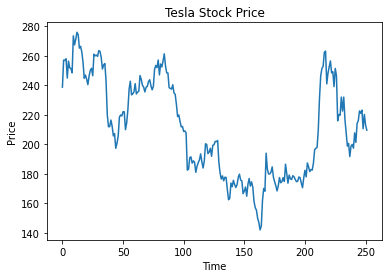

In [37]:
# Plot original data
plt.plot(df1)
plt.title('Tesla Stock Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()



In [38]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df1_scaled = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [39]:
# Split data into train and test sets
training_size = int(len(df1_scaled) * 0.7)  # Adjusted to 70% training
test_size = len(df1_scaled) - training_size
train_data, test_data = df1_scaled[0:training_size, :], df1_scaled[training_size:len(df1_scaled), :]

In [40]:
# Convert data into dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [42]:


# Define time step
time_step = 50  # Adjusted time step
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
# Ensure that X_test and y_test are not empty
if X_test.shape[0] == 0 or y_test.shape[0] == 0:
    raise ValueError("Test data is empty. Consider adjusting the time_step or data split ratio.")

In [43]:

# Reshape input for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [54]:
from tensorflow.keras.utils import plot_model

# Create the enhanced LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Plot and save the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [55]:
!pip install pydot

In [44]:


# Create the enhanced LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
2/2 [==============================] - 3s 621ms/step - loss: 0.2536 - val_loss: 0.1937
Epoch 2/100
2/2 [==============================] - 0s 76ms/step - loss: 0.1546 - val_loss: 0.0798
Epoch 3/100
2/2 [==============================] - 0s 34ms/step - loss: 0.0621 - val_loss: 0.0118
Epoch 4/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0345 - val_loss: 0.0703
Epoch 5/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0575 - val_loss: 0.0245
Epoch 6/100
2/2 [==============================] - 0s 38ms/step - loss: 0.0243 - val_loss: 0.0112
Epoch 7/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0244 - val_loss: 0.0190
Epoch 8/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0331 - val_loss: 0.0213
Epoch 9/100
2/2 [==============================] - 0s 35ms/step - loss: 0.0332 - val_loss: 0.0160
Epoch 10/100
2/2 [==============================] - 0s 36ms/step - loss: 0.0268 - val_loss: 0.0109
Epoch 11/100
2/2 [

In [45]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [46]:
# Calculate RMSE
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 204.40155072881595
Test RMSE: 210.1296701944031


In [47]:
# Plotting
look_back = 50  # Adjusted look_back
trainPredictPlot = np.empty_like(df1_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict
testPredictPlot = np.empty_like(df1_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(df1_scaled) - 1, :] = test_predict

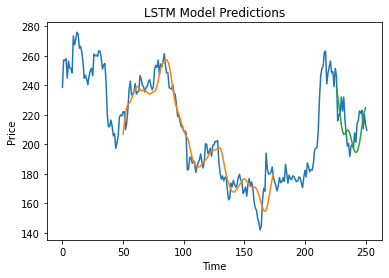

In [48]:
plt.plot(scaler.inverse_transform(df1_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('LSTM Model Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [49]:
# Forecasting future values
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = x_input.tolist()[0]

lst_output = []
n_steps = time_step
for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())

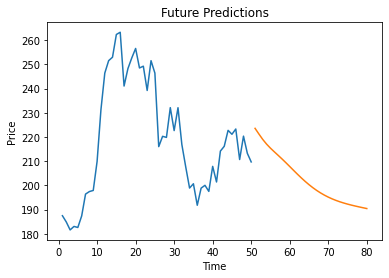

In [50]:
# Plotting future predictions
day_new = np.arange(1, time_step + 1)
day_pred = np.arange(time_step + 1, time_step + 31)
plt.plot(day_new, scaler.inverse_transform(df1_scaled[-time_step:]))
plt.plot(day_pred, scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)))
plt.title('Future Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

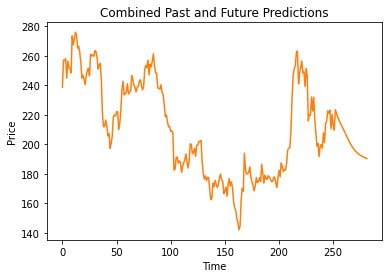

In [51]:

# Combined past and future predictions
df3 = df1_scaled.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])
df3 = scaler.inverse_transform(df3).tolist()
plt.plot(df3)
plt.title('Combined Past and Future Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()
